In [33]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import feature_selector
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import svm


In [2]:
df = pd.read_csv('train.csv.gz', sep=',').dropna()
dest = pd.read_csv('destinations.csv.gz')
df = df.sample(frac=0.01, random_state=99)
df.shape

(241179, 24)

In [49]:
from feature_selector import FeatureSelector
# Features are in train and labels are in train_labels
fs = FeatureSelector(data = df.drop(columns = 'hotel_cluster'), labels = df['hotel_cluster'])
#fs = FeatureSelector(data = df)

In [52]:
# Pass in the appropriate parameters
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 5, 
                             early_stopping = True)
# list of zero importance features
zero_importance_features = fs.ops['zero_importance']

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid_0's auc: 0.0938751
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid_0's auc: 0.152856
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[7]	valid_0's auc: 0.0557973
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	valid_0's auc: 0.0721866
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1]	valid_0's auc: 0.21456

19 features with zero importance after one-hot encoding.



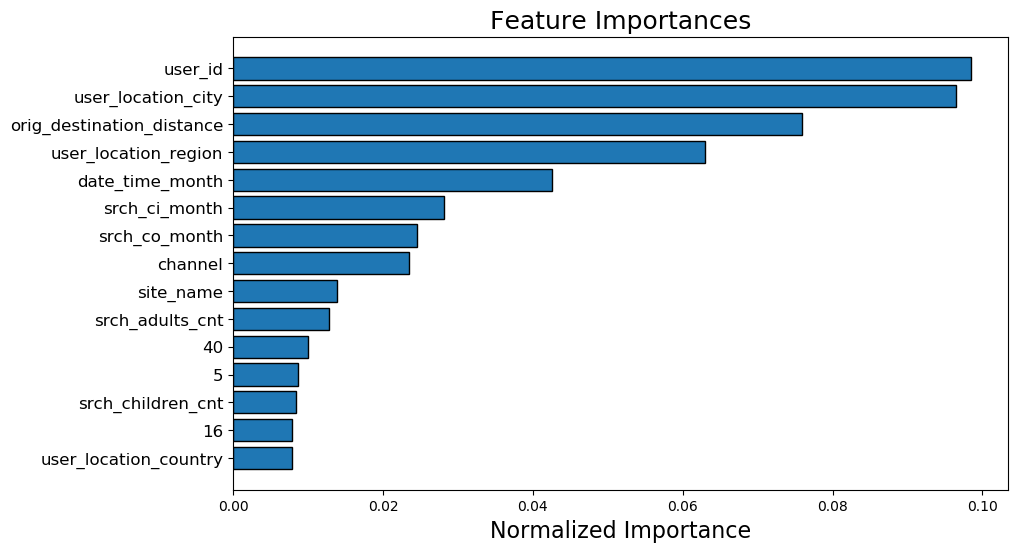

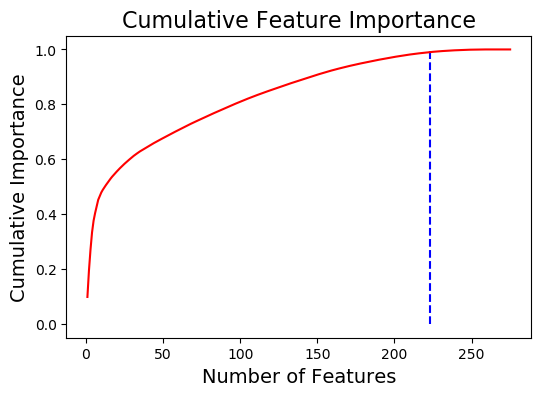

223 features required for 0.99 of cumulative importance


In [53]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 15)


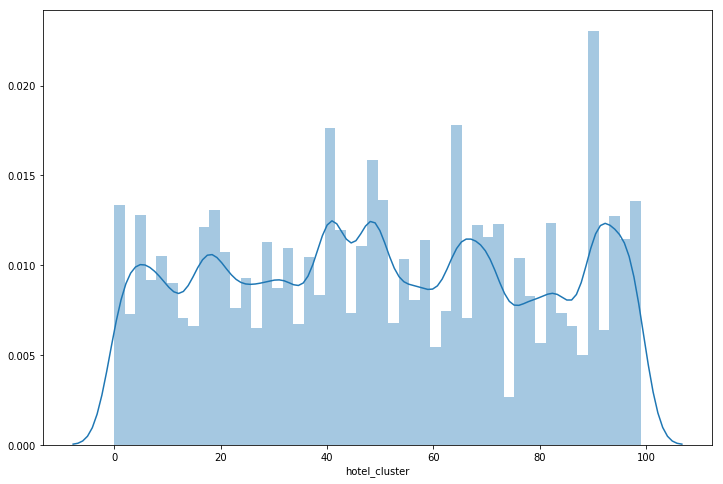

In [6]:
plt.figure(figsize=(12, 8))
sns.distplot(df['hotel_cluster'])

In [8]:
from datetime import datetime
def get_year(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013
    pass

def get_month(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass
    
def left_merge_dataset(left_dframe, right_dframe, merge_column):
    return pd.merge(left_dframe, right_dframe, on=merge_column, how='left')

In [9]:
df['date_time_year'] = pd.Series(df.date_time, index = df.index)
df['date_time_month'] = pd.Series(df.date_time, index = df.index)

from datetime import datetime
df.date_time_year = df.date_time_year.apply(lambda x: get_year(x))
df.date_time_month = df.date_time_month.apply(lambda x: get_month(x))

del df['date_time']

In [10]:
df['srch_ci_year'] = pd.Series(df.srch_ci, index=df.index)
df['srch_ci_month'] = pd.Series(df.srch_ci, index=df.index)

# convert year & months to int
df.srch_ci_year = df.srch_ci_year.apply(lambda x: get_year(x))
df.srch_ci_month = df.srch_ci_month.apply(lambda x: get_month(x))

# remove the srch_ci column
del df['srch_ci']

In [11]:
df['srch_co_year'] = pd.Series(df.srch_co, index=df.index)
df['srch_co_month'] = pd.Series(df.srch_co, index=df.index)

# convert year & months to int
df.srch_co_year = df.srch_co_year.apply(lambda x: get_year(x))
df.srch_co_month = df.srch_co_month.apply(lambda x: get_month(x))

# remove the srch_co column
del df['srch_co']

In [20]:
df.corr()["hotel_cluster"].sort_values()

7               -0.116262
6               -0.106524
13              -0.095484
15              -0.090694
16              -0.088875
5               -0.084847
1               -0.083672
28              -0.079407
24              -0.078899
45              -0.077661
2               -0.076054
d20             -0.073708
4               -0.071221
10              -0.066341
8               -0.062310
18              -0.060886
32              -0.059473
88              -0.057693
14              -0.057053
79              -0.054750
11              -0.053527
0               -0.049698
9               -0.049478
d14             -0.047428
25              -0.046378
49              -0.045783
19              -0.043126
33              -0.040937
23              -0.039137
3               -0.034756
                   ...   
72               0.039352
67               0.045490
89               0.045777
86               0.047253
92               0.049853
41               0.050112
78               0.051393
93          

In [72]:
pieces = [df.groupby(['orig_destination_distance','user_location_city','srch_destination_id','hotel_cluster'])['is_booking'].agg(['sum','count'])]
#print(pieces)
agg = pd.concat(pieces).groupby(level=[0,1,2,3]).sum()
agg.dropna(inplace=True)

agg.head()

sum  \
orig_destination_distance user_location_city srch_destination_id hotel_cluster        
0.0056                    15538              59393               16               1   
                          16923              7791                48               1   
0.0116                    9606               15817               48               1   
0.0170                    53288              26490               32               1   
0.0287                    1658               26423               91               1   

                                                                                count  
orig_destination_distance user_location_city srch_destination_id hotel_cluster         
0.0056                    15538              59393               16                 1  
                          16923              7791                48                 1  
0.0116                    9606               15817               48                 1  
0.0170                    53288              26490               32                 1  
0.0287                    1658               26423               91                 1

In [57]:
agg['sum_and_cnt'] = 0.85*agg['sum'] + 0.15*agg['count']
agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)
agg.head()

,orig_destination_distance,user_location_city,srch_destination_id,hotel_cluster,sum,count,sum_and_cnt
0,0.0056,15538,59393,16,1.0,1.0,1.0
1,0.0056,16923,7791,48,1.0,1.0,1.0
2,0.0116,9606,15817,48,1.0,1.0,1.0
3,0.0170,53288,26490,32,1.0,1.0,1.0
4,0.0287,1658,26423,91,1.0,1.0,1.0


In [61]:
agg_pivot = agg.pivot_table(index=['orig_destination_distance','user_location_city','srch_destination_id'], columns='hotel_cluster', values='sum_and_cnt').reset_index()
agg_pivot.head()

hotel_cluster,orig_destination_distance,user_location_city,srch_destination_id,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,0.0056,15538,59393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0056,16923,7791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0116,9606,15817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0170,53288,26490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0287,1658,26423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
df = pd.merge(df, dest, how='left', on='srch_destination_id')
df = pd.merge(df, agg_pivot, how='left', on=['srch_destination_id','orig_destination_distance','user_location_city'])
df.fillna(0, inplace=True)
df.shape

(20032, 525)

In [63]:
df = df.loc[df['is_booking'] == 1]

In [64]:
X = df.drop(['user_id', 'hotel_cluster', 'is_booking'], axis=1)
y = df.hotel_cluster

In [65]:
from sklearn import svm

clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(decision_function_shape='ovo'))
np.mean(cross_val_score(clf, X, y, cv=10))

0.9951626395940838

In [69]:
clf.fit(X,y)


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])